# Plant Disease Detection Code

## Import Dependencies

In [1]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Torch
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [3]:
# A simple extension for Jupyter Notebook and Jupyter Lab to beautify Python code automatically using Black.
%load_ext nb_black


<IPython.core.display.Javascript object>

## Import Dataset

Transforms are used for Data Augmentation like cropping the image, resize the image, convert the image to tensor, rotate the image, and many more. Transforms work as a filter for all images. We are using the following code to transform the images.

In [26]:
transform = transforms.Compose(
    [transforms.Resize(255),
     transforms.RandomCrop(224, 10),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor()]
)


<IPython.core.display.Javascript object>

In [27]:
dataset = datasets.ImageFolder(
    "Plant_leave_diseases_dataset_with_augmentation", transform=transform)


<IPython.core.display.Javascript object>

In [56]:
dataset

Dataset ImageFolder
    Number of datapoints: 61468
    Root location: Plant_leave_diseases_dataset_with_augmentation
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               RandomCrop(size=(224, 224), padding=10)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

<IPython.core.display.Javascript object>

In [49]:
import os
def make_directories(input_list):
    dirpath = os.path.join('./Augmented/', input_list)
    try:
        os.mkdir(dirpath)
    except FileExistsError:
        print('Directory {} already exists'.format(dirpath))
    else:
        print('Directory {} created'.format(dirpath))


   


<IPython.core.display.Javascript object>

In [ ]:
# model.class_to_idx = dataset.class_to_idx
# model.class_to_idx.items()
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
i = 1

for tensor, label in dataset:
    clas = idx_to_class[label]
    os.chdir("/Users/gauthierheroufosse/Documents/Studies/MA 1/Q1/DataSciences - Partim B/Model/Augmented/{}/".format(clas))
    torch.save(tensor,'tensor {}'.format(i))
    i+=1
    



## Split into Train and Test


In [10]:
indices = list(range(len(dataset)))
split = int(np.floor(0.85 * len(dataset)))  # train_size
validation = int(np.floor(0.70 * split))  # validation
#print(0, validation, split, len(dataset))
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")


length of train size :36572
length of validation size :15675
length of test size :24896


<IPython.core.display.Javascript object>

Like this, we use ~60% for training and ~40% for testing.
About validation data :

If you want to build a solid model you have to follow that specific protocol of splitting your data into three sets: One for training, one for validation and one for final evaluation, which is the test set.

The idea is that you train on your training data and tune your model with the results of metrics (accuracy, loss etc) that you get from your validation set.

Your model doesn't "see" your validation set and isn't in any way trained on it, but you as the architect and master of the hyperparameters tune the model according to this data. Therefore it indirectly influences your model because it directly influences your design decisions. You nudge your model to work well with the validation data and that can possibly bring in a tilt.

Exactly that is the reason you only evaluate your model's final score on data that neither your model nor you yourself has used – and that is the third chunk of data, your test set.

Only this procedure makes sure you get an unaffected view of your models quality and ability to generalize what is has learned on totally unseen data.

In [8]:
# randomize the choice of test, train and validation images
np.random.shuffle(indices)


<IPython.core.display.Javascript object>

In [9]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

<IPython.core.display.Javascript object>

Here in the above code we first getting indices and then split the data into train , test and validation data. Total 36584 for train , 15679 for validaiton and remaining images for testing.

In [10]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)


<IPython.core.display.Javascript object>

SubsetRandomSampler is used to sample our data. Here we are creating an object of SubsetRandomSampler Object and later we will use this sampler in train data loader and test data loader.

In [12]:
targets_size = len(dataset.class_to_idx)

<IPython.core.display.Javascript object>

## Model


Convolution Aithmetic Equation : (W - F + 2P) / S + 1
W = Input Size
F = Filter Size
P = Padding Size
S = Stride

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()


for param in model.parameters():
    param.requires_grad = False
    
fc_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(fc_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 39),
)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


<IPython.core.display.Javascript object>

In [15]:
device = "cpu"


<IPython.core.display.Javascript object>

In [19]:
#model = CNN(targets_size)


<IPython.core.display.Javascript object>

In [ ]:
model.to(device)


In [ ]:
from torchsummary import summary
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

summary(model, (3, 224, 224))


## Batch Gradient Descent

In [18]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    
    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()
            

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:
            
            model.eval()

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world
        
        
        
        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss: {train_loss:.3f} Validation_loss: {validation_loss:.3f} Duration: {dt}"
        )

    return train_losses, validation_losses
 #accuracy += torch.mean(equals.type(torch.FloatTensor))


<IPython.core.display.Javascript object>

In [19]:
device = "cpu"

<IPython.core.display.Javascript object>

In [20]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)


<IPython.core.display.Javascript object>

In [26]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 5
)



Epoch : 1/5 Train_loss: 1.228 Validation_loss: 0.409 Duration: 1:25:59.295628
Epoch : 2/5 Train_loss: 1.095 Validation_loss: 0.390 Duration: 1:30:05.247452
Epoch : 3/5 Train_loss: 1.063 Validation_loss: 0.355 Duration: 2:26:17.644445
Epoch : 4/5 Train_loss: 1.047 Validation_loss: 0.343 Duration: 1:45:46.607580
Epoch : 5/5 Train_loss: 1.038 Validation_loss: 0.330 Duration: 5:03:55.402497


<IPython.core.display.Javascript object>

## Save the model

In [28]:
torch.save(model.state_dict() , 'plant_disease_model_1.pt')


<IPython.core.display.Javascript object>

## Load the model

In [ ]:
targets_size = 39
#model = CropDetectCNN()
model.load_state_dict(torch.load("plant_disease_model_1_latest.pt"))
model.eval()


## Plot the loss

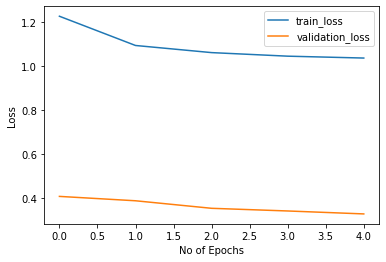

<IPython.core.display.Javascript object>

In [27]:
plt.plot(train_losses, label='train_loss')
plt.plot(validation_losses, label='validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Accuracy

In [28]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model.eval()
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc


train_acc = accuracy(train_loader)
validation_acc = accuracy(validation_loader)
test_acc = accuracy(test_loader)

print(
    f"Train Accuracy : {train_acc}\nValidation Accuracy : {validation_acc}\nTest Accuracy : {test_acc}"
)

Train Accuracy : 0.9080745681172097
Validation Accuracy : 0.899674724153326
Test Accuracy : 0.9071885503632223


<IPython.core.display.Javascript object>